In [35]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

print("Tensor flow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

Tensor flow version: 1.13.1
Eager execution: True


Download the data

In [4]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(
    fname = os.path.basename(train_dataset_url),
    origin = train_dataset_url
)

8192/2194 [================================================================================================================] - 0s 0us/step


In [6]:
print("Local copy of dataset: {}".format(train_dataset_fp))

Local copy of dataset: C:\Users\Kev\.keras\datasets\iris_training.csv


Inspect the data

In [7]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


Labels description
0: iris setosa
1: iris versicolor
2: iris virginica

In [9]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Labels: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Labels: species


Create a tf.data.Dataset

In [12]:
batch_size = 32
train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names = column_names,
    label_name = label_name,
    num_epochs = 1
)

In [15]:
features, labels = next(iter(train_dataset))
features

OrderedDict([('sepal_length',
              <tf.Tensor: id=134, shape=(32,), dtype=float32, numpy=
              array([6.7, 6.2, 6.4, 7.2, 7.7, 6.7, 5.4, 5.1, 5.9, 5.7, 6.3, 4.6, 6.2,
                     6.8, 5.1, 6.3, 5.7, 5.2, 5.5, 5.8, 5.5, 4.9, 5.3, 6.4, 6.5, 4.4,
                     5. , 7.2, 5.4, 5. , 5. , 6.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=135, shape=(32,), dtype=float32, numpy=
              array([3. , 3.4, 2.8, 3.2, 2.6, 3.1, 3.9, 3.7, 3.2, 2.8, 3.3, 3.1, 2.8,
                     3.2, 3.8, 2.3, 3.8, 3.4, 3.5, 2.7, 2.4, 3.1, 3.7, 2.8, 2.8, 3. ,
                     3.6, 3.6, 3.7, 3.5, 3.5, 3. ], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=132, shape=(32,), dtype=float32, numpy=
              array([5.2, 5.4, 5.6, 6. , 6.9, 5.6, 1.7, 1.5, 4.8, 4.1, 4.7, 1.5, 4.8,
                     5.9, 1.9, 4.4, 1.7, 1.4, 1.3, 5.1, 3.8, 1.5, 1.5, 5.6, 4.6, 1.3,
                     1.4, 6.1, 1.5, 1.6, 1.3, 5.

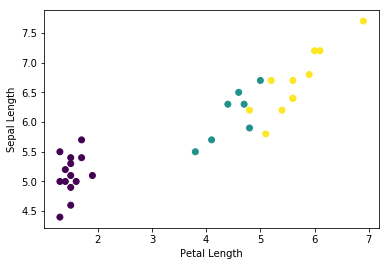

In [16]:
plt.scatter(
    features['petal_length'].numpy(),
    features['sepal_length'].numpy(),
    c = labels.numpy(),
    cmap = 'viridis'
)

plt.xlabel('Petal Length')
plt.ylabel('Sepal Length')
plt.show()

In [22]:
def pack_feature_vector(features, labels):
    """Pack features into a single array"""
    features = tf.stack(list(features.values()), axis = 1)
    return features, labels

In [23]:
# Pack the features pairs of each (features, label) into the training dataset
train_dataset = train_dataset.map(pack_feature_vector)

# Look at the features dataset array that's now an array of shape (batch_size, num_features)
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[5.2 3.5 1.5 0.2]
 [4.7 3.2 1.3 0.2]
 [5.  3.5 1.3 0.3]
 [5.7 4.4 1.5 0.4]
 [4.6 3.1 1.5 0.2]], shape=(5, 4), dtype=float32)


# Model selection and training

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)),
    tf.keras.layers.Dense(10, activation = tf.nn.relu),
    tf.keras.layers.Dense(3)
])

In [39]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=317, shape=(5, 3), dtype=float32, numpy=
array([[ 1.6632625 ,  0.8922211 , -2.4476905 ],
       [ 1.527781  ,  0.8115667 , -2.232955  ],
       [ 1.6886642 ,  0.88337004, -2.4410298 ],
       [ 2.022076  ,  1.0051411 , -2.8662271 ],
       [ 1.4508618 ,  0.8095895 , -2.17681   ]], dtype=float32)>

In [41]:
# Convert the logits to a probability for each class
tf.nn.softmax(predictions[:5])
print("Predictions: {}".format(tf.argmax(predictions, axis = 1)))
print("Labels: {}".format(labels))

Predictions: [0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0]
Labels: [0 0 0 0 0 2 0 2 2 0 2 0 1 2 2 1 0 1 0 2 2 2 1 1 1 0 0 0 2 1 2 1]


Define the Loss Gradient Function

In [45]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

In [47]:
l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 2.4048800468444824


In [48]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)